In [3]:
import os
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from PIL import Image 

torch.backends.cudnn.deterministic = True



In [4]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)


Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
---
matplotlib version: 3.7.2
pandas version: 2.2.3
PIL version: 11.3.0
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [5]:
# Set device
if torch.cuda.is_available():
    device = "cuda"
    print(f"Using device: {device}")
else:
    device = "cpu"
    print(f"Using device: {device}")

Using device: cuda


In [6]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img



# Enhanced training transforms with better augmentation
train_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation/Test transforms (no augmentation)
val_transforms = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Training transforms:")
print(train_transforms)
print("\nValidation transforms:")
print(val_transforms)

Training transforms:
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

Validation transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [7]:
# ================================
# 2. LOAD DATASETS
# ================================

train_dir = "/kaggle/input/kidney-image-dataset/Kidney Dataset/train"
val_dir   = "/kaggle/input/kidney-image-dataset/Kidney Dataset/valid"
test_dir  = "/kaggle/input/kidney-image-dataset/Kidney Dataset/test"


In [8]:

train_datasets = datasets.ImageFolder(root=train_dir, transform=train_transforms)
validation_datasets = datasets.ImageFolder(root=val_dir, transform=val_transforms)
test_datasets = datasets.ImageFolder(root=test_dir, transform=val_transforms)

print("Number of classes:", len(train_datasets.classes))
class_names = train_datasets.classes
print("Class names:", class_names)

Number of classes: 4
Class names: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [9]:
# Analyze class distribution
class_counts = Counter([label for _, label in train_datasets])
for class_index, count in class_counts.items():
    class_name = class_names[class_index]
    print(f"Class '{class_name}' has {count} images.")
print("Total number of training images:", len(train_datasets))
print("Total number of validation images:", len(validation_datasets))
print("Total number of test images:", len(test_datasets))

Class 'Cyst' has 2597 images.
Class 'Normal' has 3553 images.
Class 'Stone' has 963 images.
Class 'Tumor' has 1599 images.
Total number of training images: 8712
Total number of validation images: 1867
Total number of test images: 1867


In [10]:
sample_file = "/kaggle/input/kidney-image-dataset/Kidney Dataset/train/Stone/Stone- (1001).jpg"

image = Image.open(sample_file)

transformed_image = train_transforms(image)
print(transformed_image.shape)


torch.Size([3, 224, 224])


In [11]:
# ================================
# 3. CREATE DATA LOADERS
# ================================

batch_size = 32
g = torch.Generator()
g.manual_seed(42)

train_loader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True, generator=g)
val_loader = DataLoader(validation_datasets, batch_size=batch_size, shuffle=False, generator=g)
test_loader = DataLoader(test_datasets, batch_size=batch_size, shuffle=False, generator=g)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Verify batch shape
single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Train batches: 273
Val batches: 59
Test batches: 59
Shape of one batch: torch.Size([32, 3, 224, 224])


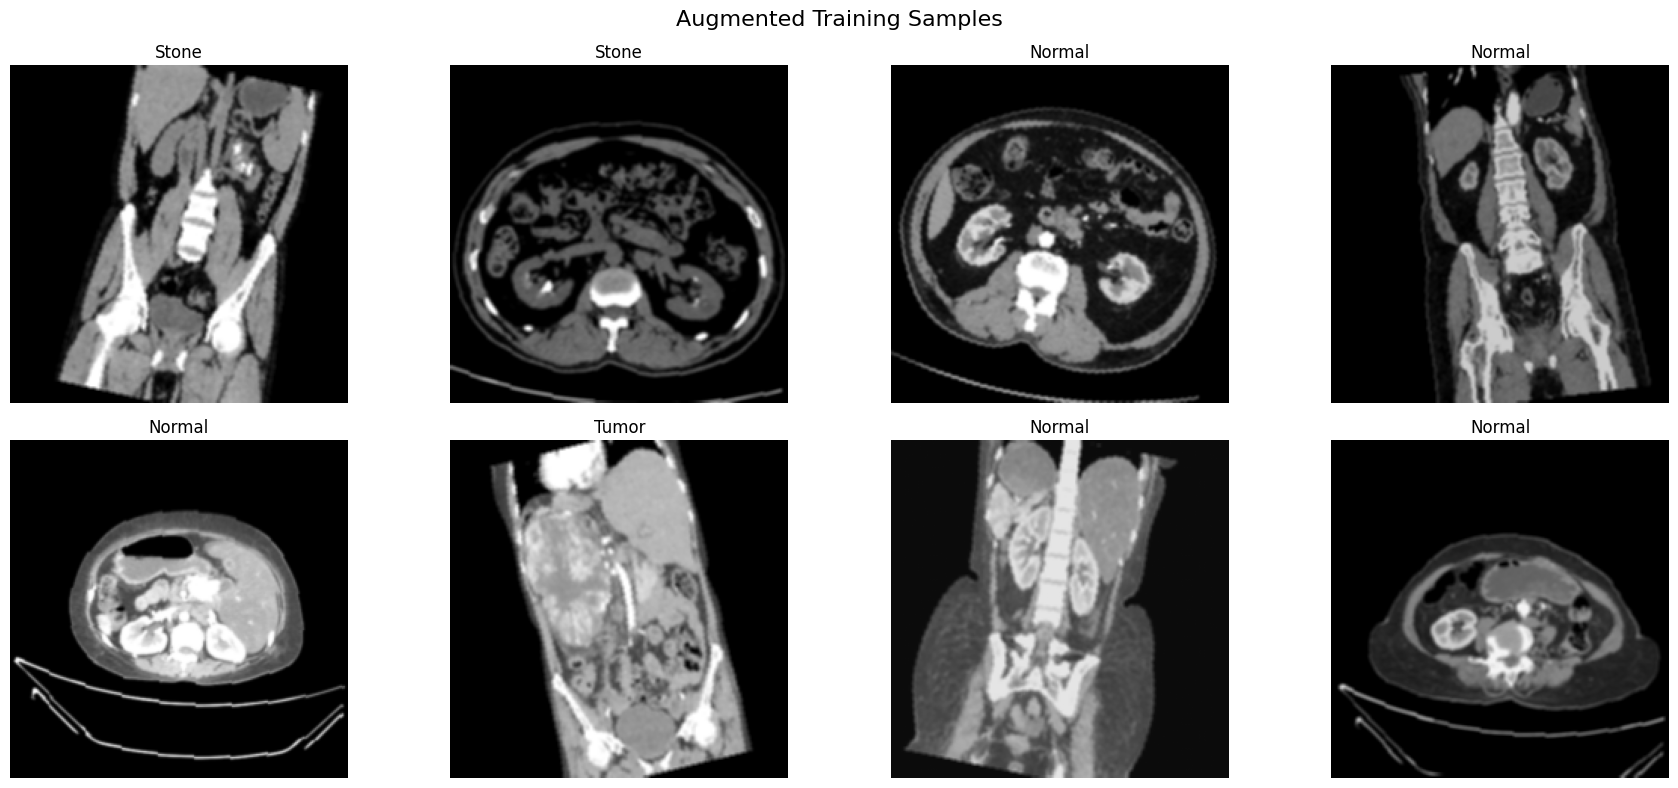

In [12]:
# ================================
# 4. VISUALIZE AUGMENTED SAMPLES
# ================================

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
for i in range(8):
    img = images[i].permute(1, 2, 0)  # C,H,W -> H,W,C
    # Denormalize for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = torch.clamp(img, 0, 1)
    
    ax = axes[i//4, i%4]
    ax.imshow(img)
    ax.set_title(f"{class_names[labels[i]]}")
    ax.axis('off')

plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
classes = os.listdir(train_dir)

In [14]:
# Import the function first
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_counts = np.array([2597, 3553, 963, 1599])
class_labels = np.arange(4)

weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=np.repeat(class_labels, class_counts)
)

weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class Weights:", weights)



Class Weights: tensor([0.8387, 0.6130, 2.2617, 1.3621], device='cuda:0')


In [15]:
import random
def sample_images(data_path, classname):
    # Gets the files in the directory
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

Cyst


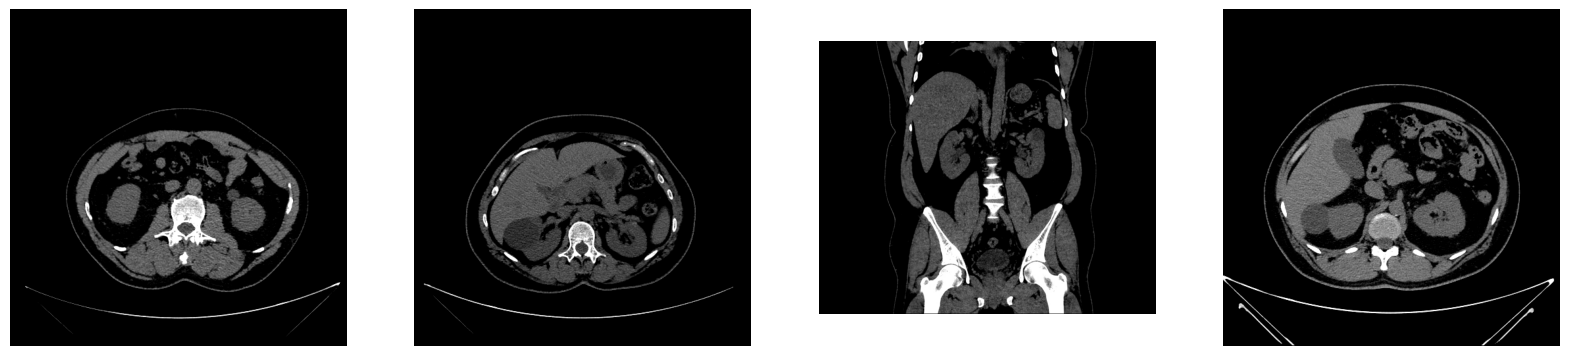

In [16]:
class_name = classes[0]
print(class_name)

sample_images(train_dir, class_name)

Tumor


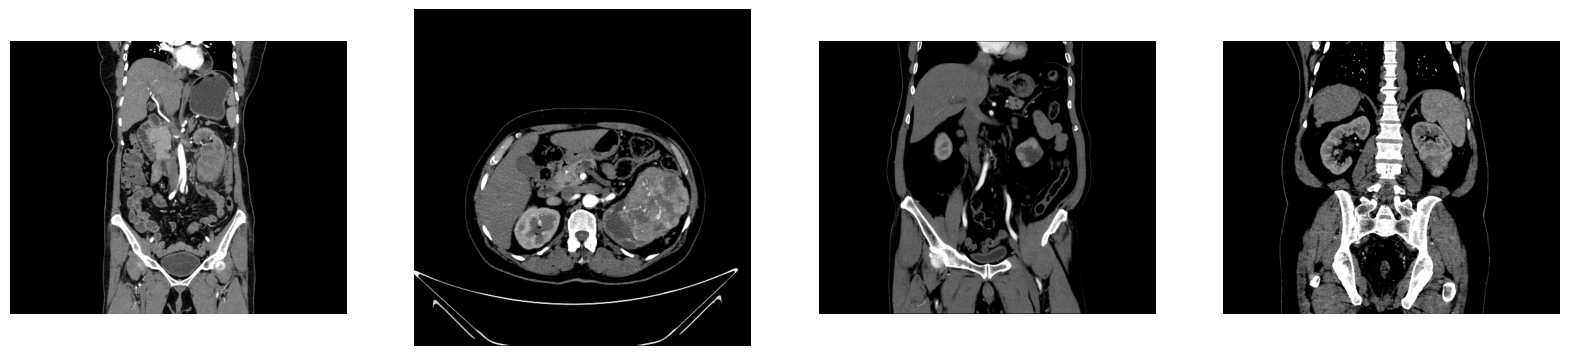

In [17]:
class_name = classes[1]
print(class_name)

sample_images(train_dir, class_name)

Stone


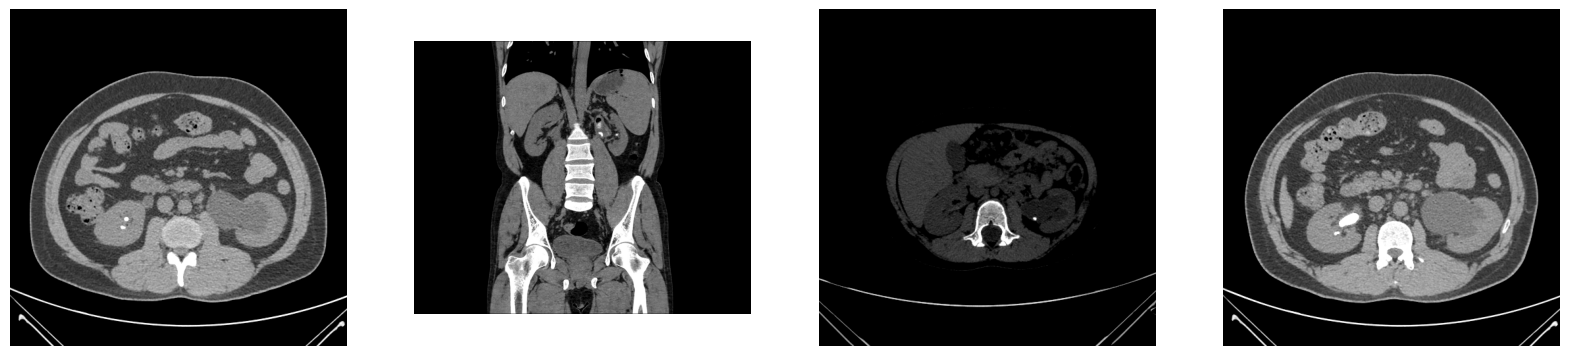

In [18]:
class_name = classes[2]
print(class_name)

sample_images(train_dir, class_name)

Normal


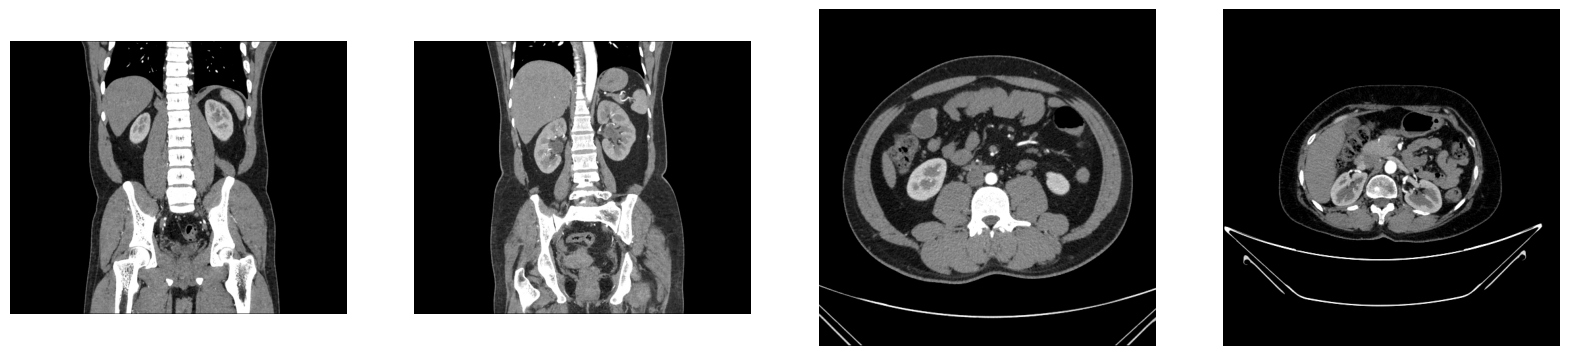

In [19]:
class_name = classes[3]
print(class_name)

sample_images(train_dir, class_name)

# Move class_weights to CPU for indexing
class_weights_cpu = class_weights.cpu().numpy()

# Assign weight to each sample
samples_weights = np.array([class_weights_cpu[label] for label in y_train_numpy])

# Convert to torch tensor
samples_weights = torch.from_numpy(samples_weights).double()

# Create the sampler
from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(
    samples_weights, 
    num_samples=len(samples_weights), 
    replacement=True
)

# Recreate train_loader with sampler
train_loader = DataLoader(
    train_datasets, 
    batch_size=batch_size, 
    sampler=sampler,
    num_workers=4
)


In [20]:
from torchvision import models

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)   # 4 classes
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


In [21]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [22]:
# ================================
# 8. TRAINING LOOP WITH METRICS TRACKING
# ================================

# Training configuration
num_epochs = 30
early_stop_patience = 7
best_val_loss = float("inf")
early_stop_counter = 0
best_model_path = "Bestresnet50_kidney_best_weights.pth"

# Metrics tracking
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Starting training...")
print("=" * 80)

for epoch in range(1, num_epochs + 1):
    # ---- TRAINING PHASE ----
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]")
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        batch_size = images.size(0)
        train_loss += loss.item() * batch_size
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += batch_size
        
        # Update progress bar
        train_bar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{(outputs.argmax(1) == labels).float().mean().item():.4f}"
        })
    
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    
    # ---- VALIDATION PHASE ----
    model.eval()
    val_loss, val_correct = 0, 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]")
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            
            val_bar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Acc': f"{(outputs.argmax(1) == labels).float().mean().item():.4f}"
            })
    
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Update scheduler
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # ---- EPOCH SUMMARY ----
    print(f"\nEpoch {epoch} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"  Learning Rate: {current_lr:.2e}")
    
    # ---- EARLY STOPPING CHECK ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("  ✓ Model improved - saved")
    else:
        early_stop_counter += 1
        print(f"  ⚠ No improvement: {early_stop_counter}/{early_stop_patience}")
        
        if early_stop_counter >= early_stop_patience:
            print("   Early stopping triggered!")
            break
    
    print("-" * 60)

# Load best model
model.load_state_dict(torch.load(best_model_path))
print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")

Starting training...


Epoch 1/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 0.3419 | Train Acc: 0.8790
  Val Loss: 0.3374 | Val Acc: 0.8720
  Learning Rate: 1.00e-04
  ✓ Model improved - saved
------------------------------------------------------------


Epoch 2/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 0.0417 | Train Acc: 0.9888
  Val Loss: 0.2769 | Val Acc: 0.8913
  Learning Rate: 1.00e-04
  ✓ Model improved - saved
------------------------------------------------------------


Epoch 3/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 0.0276 | Train Acc: 0.9927
  Val Loss: 0.7349 | Val Acc: 0.8340
  Learning Rate: 1.00e-04
  ⚠ No improvement: 1/7
------------------------------------------------------------


Epoch 4/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 0.0236 | Train Acc: 0.9932
  Val Loss: 0.4235 | Val Acc: 0.8886
  Learning Rate: 1.00e-04
  ⚠ No improvement: 2/7
------------------------------------------------------------


Epoch 5/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 0.0136 | Train Acc: 0.9968
  Val Loss: 0.5318 | Val Acc: 0.8377
  Learning Rate: 5.00e-05
  ⚠ No improvement: 3/7
------------------------------------------------------------


Epoch 6/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 0.0070 | Train Acc: 0.9982
  Val Loss: 0.2123 | Val Acc: 0.9309
  Learning Rate: 5.00e-05
  ✓ Model improved - saved
------------------------------------------------------------


Epoch 7/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 0.0058 | Train Acc: 0.9986
  Val Loss: 0.1854 | Val Acc: 0.9497
  Learning Rate: 5.00e-05
  ✓ Model improved - saved
------------------------------------------------------------


Epoch 8/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 0.0028 | Train Acc: 0.9994
  Val Loss: 0.2859 | Val Acc: 0.9138
  Learning Rate: 5.00e-05
  ⚠ No improvement: 1/7
------------------------------------------------------------


Epoch 9/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss: 0.0027 | Train Acc: 0.9992
  Val Loss: 0.2248 | Val Acc: 0.9432
  Learning Rate: 5.00e-05
  ⚠ No improvement: 2/7
------------------------------------------------------------


Epoch 10/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss: 0.0042 | Train Acc: 0.9990
  Val Loss: 0.3776 | Val Acc: 0.9164
  Learning Rate: 2.50e-05
  ⚠ No improvement: 3/7
------------------------------------------------------------


Epoch 11/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 11 Summary:
  Train Loss: 0.0041 | Train Acc: 0.9987
  Val Loss: 0.3014 | Val Acc: 0.9282
  Learning Rate: 2.50e-05
  ⚠ No improvement: 4/7
------------------------------------------------------------


Epoch 12/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 12 Summary:
  Train Loss: 0.0050 | Train Acc: 0.9987
  Val Loss: 0.5234 | Val Acc: 0.8650
  Learning Rate: 2.50e-05
  ⚠ No improvement: 5/7
------------------------------------------------------------


Epoch 13/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 13 Summary:
  Train Loss: 0.0024 | Train Acc: 0.9995
  Val Loss: 0.4691 | Val Acc: 0.8768
  Learning Rate: 2.50e-05
  ⚠ No improvement: 6/7
------------------------------------------------------------


Epoch 14/30 [Train]:   0%|          | 0/273 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/59 [00:00<?, ?it/s]


Epoch 14 Summary:
  Train Loss: 0.0009 | Train Acc: 0.9999
  Val Loss: 0.3604 | Val Acc: 0.8972
  Learning Rate: 2.50e-05
  ⚠ No improvement: 7/7
   Early stopping triggered!

Training completed! Best validation loss: 0.1854


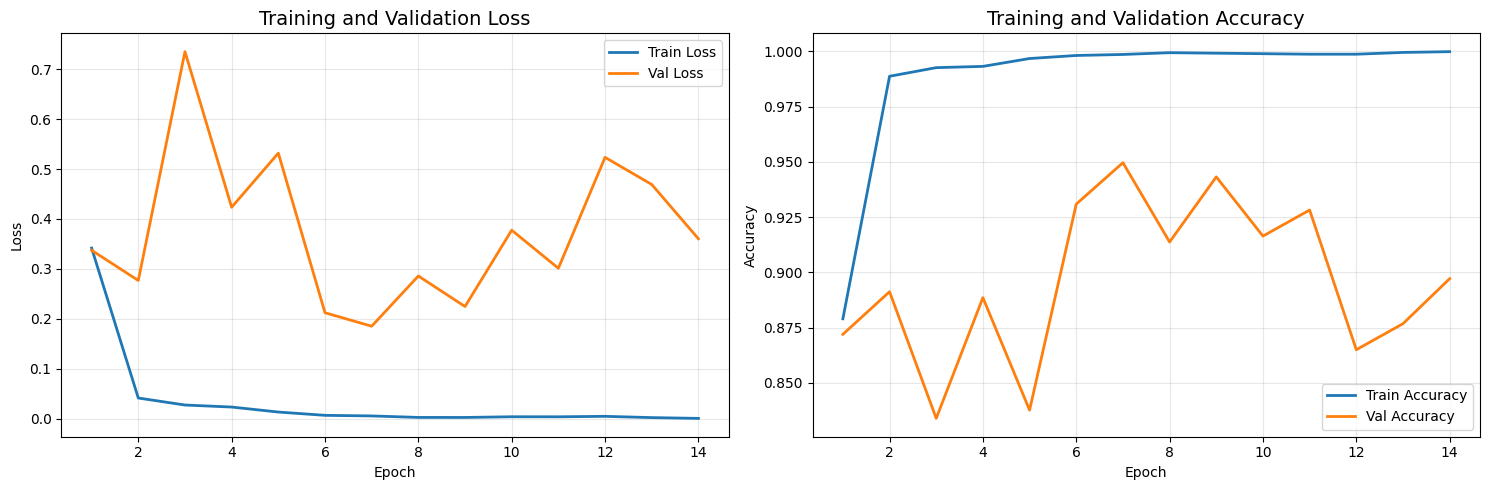

In [23]:
# ================================
# 9. PLOT TRAINING HISTORY
# ================================

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    epochs_range = range(1, len(train_losses) + 1)
    ax1.plot(epochs_range, train_losses, label='Train Loss', linewidth=2)
    ax1.plot(epochs_range, val_losses, label='Val Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs_range, train_accs, label='Train Accuracy', linewidth=2)
    ax2.plot(epochs_range, val_accs, label='Val Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accs, val_accs)

Test Set Evaluation:


Evaluating:   0%|          | 0/59 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      0.98      0.99       556
      Normal       0.98      0.99      0.99       762
       Stone       0.94      0.99      0.96       207
       Tumor       0.99      0.96      0.97       342

    accuracy                           0.98      1867
   macro avg       0.98      0.98      0.98      1867
weighted avg       0.98      0.98      0.98      1867



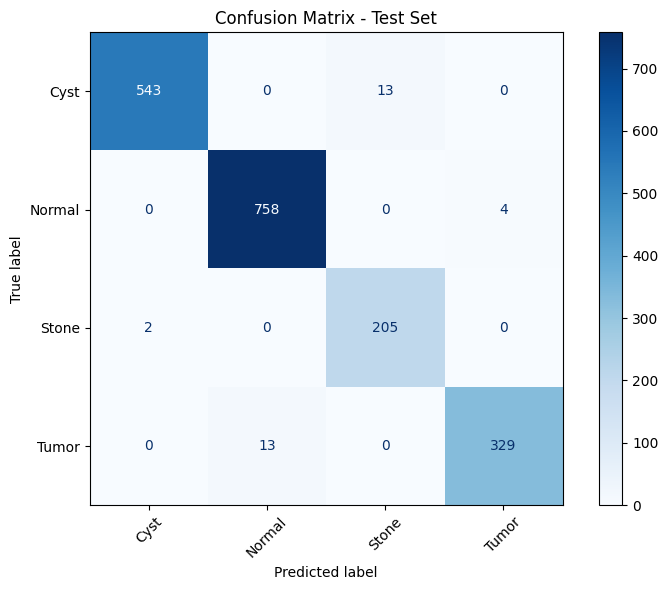

In [24]:
# ================================
# 10. MODEL EVALUATION
# ================================
from sklearn.metrics import classification_report
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return all_preds, all_labels, all_probs

print("Test Set Evaluation:")
test_preds, test_labels, test_probs = evaluate_model(model, test_loader, class_names)

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sample Predictions:


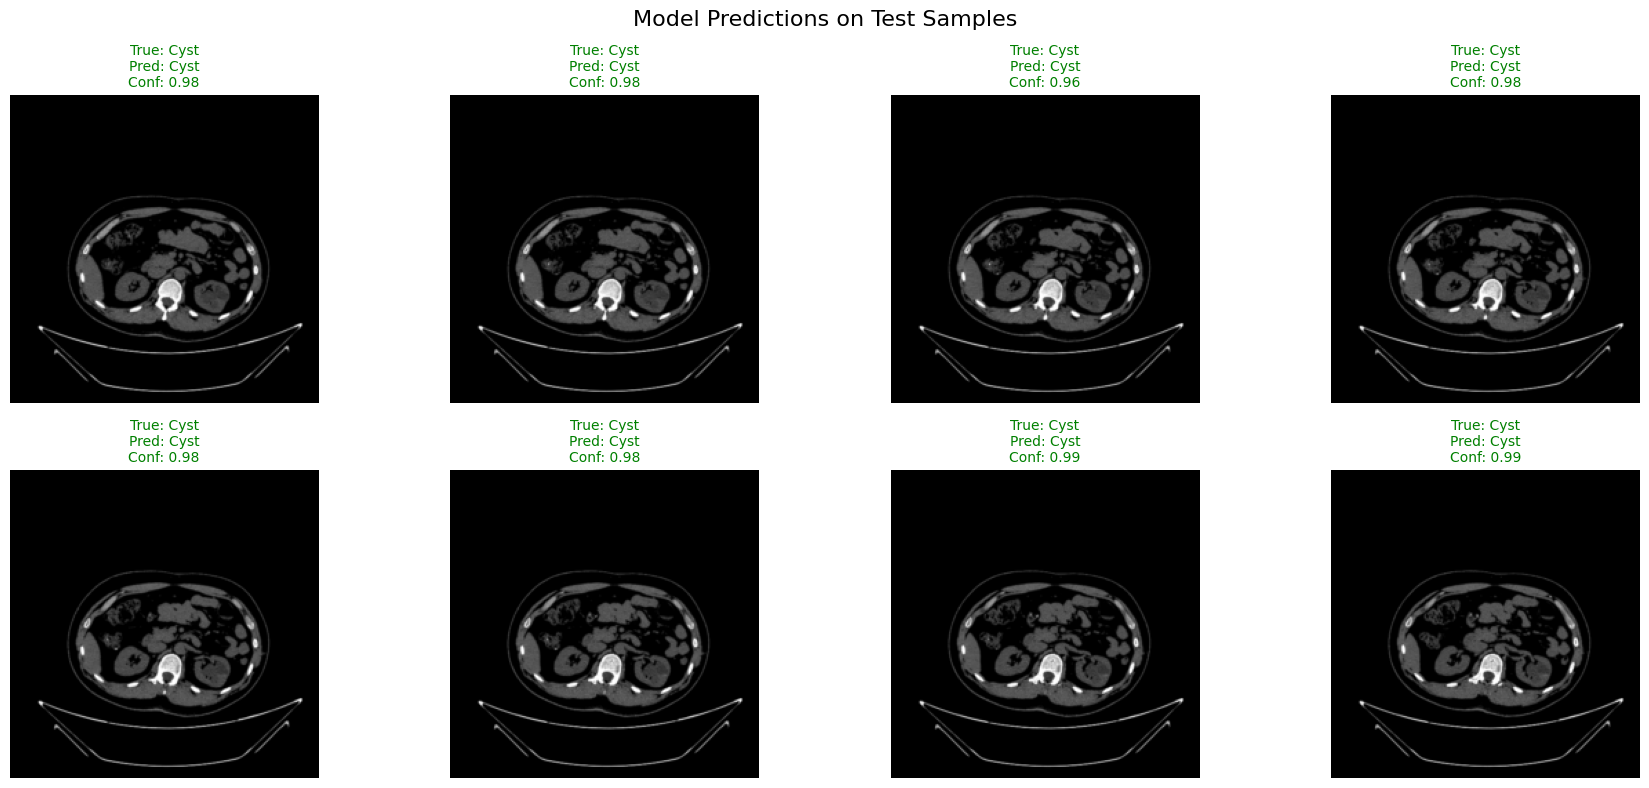

In [25]:
# ================================
# 11. SAMPLE PREDICTIONS VISUALIZATION
# ================================

def visualize_predictions(model, dataloader, class_names, num_samples=8):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images[:num_samples])
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))
    for i in range(num_samples):
        img = images[i].cpu().permute(1, 2, 0)  # C,H,W -> H,W,C
        # Denormalize
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)
        
        ax = axes[i//4, i%4]
        ax.imshow(img)
        
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        confidence = probs[i][preds[i]].item()
        
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", 
                    color=color, fontsize=10)
        ax.axis('off')
    
    plt.suptitle("Model Predictions on Test Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

print("Sample Predictions:")
visualize_predictions(model, test_loader, class_names)

In [29]:
# ================================
# 12. TEST ACCURACY & TEST LOSS
# ================================

def evaluate_test_set(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = test_loss / total
    accuracy = correct / total

    return avg_loss, accuracy, all_labels, all_preds


# RUN EVALUATION
test_loss, test_acc, y_true, y_pred = evaluate_test_set(model, test_loader, criterion, device)

print("===========================================")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print("===========================================")


Test Loss: 0.0510
Test Accuracy: 98.29%


In [31]:
# ================================
# 12. TEST ACCURACY, LOSS, & METRICS
# ================================

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_test_set(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = test_loss / total
    accuracy = correct / total

    # Compute Precision, Recall, F1-Score (macro average for multi-class)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds


# RUN EVALUATION
test_loss, test_acc, precision, recall, f1, y_true, y_pred = evaluate_test_set(model, test_loader, criterion, device)

print("===========================================")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
print("===========================================")


Test Loss: 0.0510
Test Accuracy: 98.29%
Precision: 97.70%
Recall: 98.09%
F1 Score: 97.87%


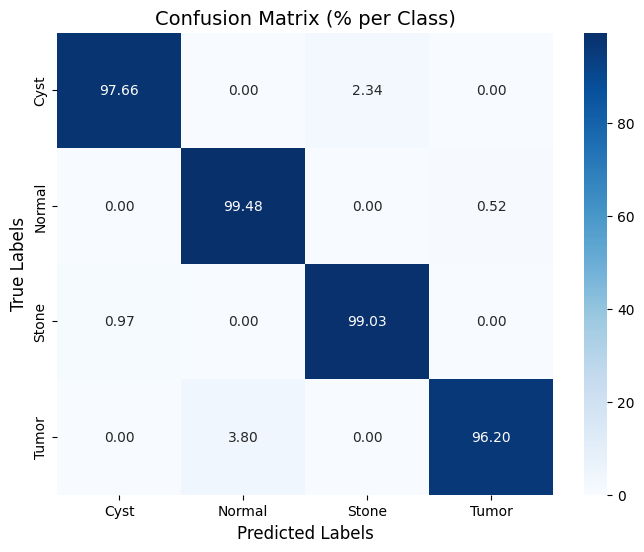

In [34]:
# ================================
# 13. CONFUSION MATRIX WITH LABELS
# ================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Class names
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix (% per Class)', fontsize=14)
plt.show()


🔄 Collecting 100 random predictions from test set...
✓ Collected 100 samples for visualization


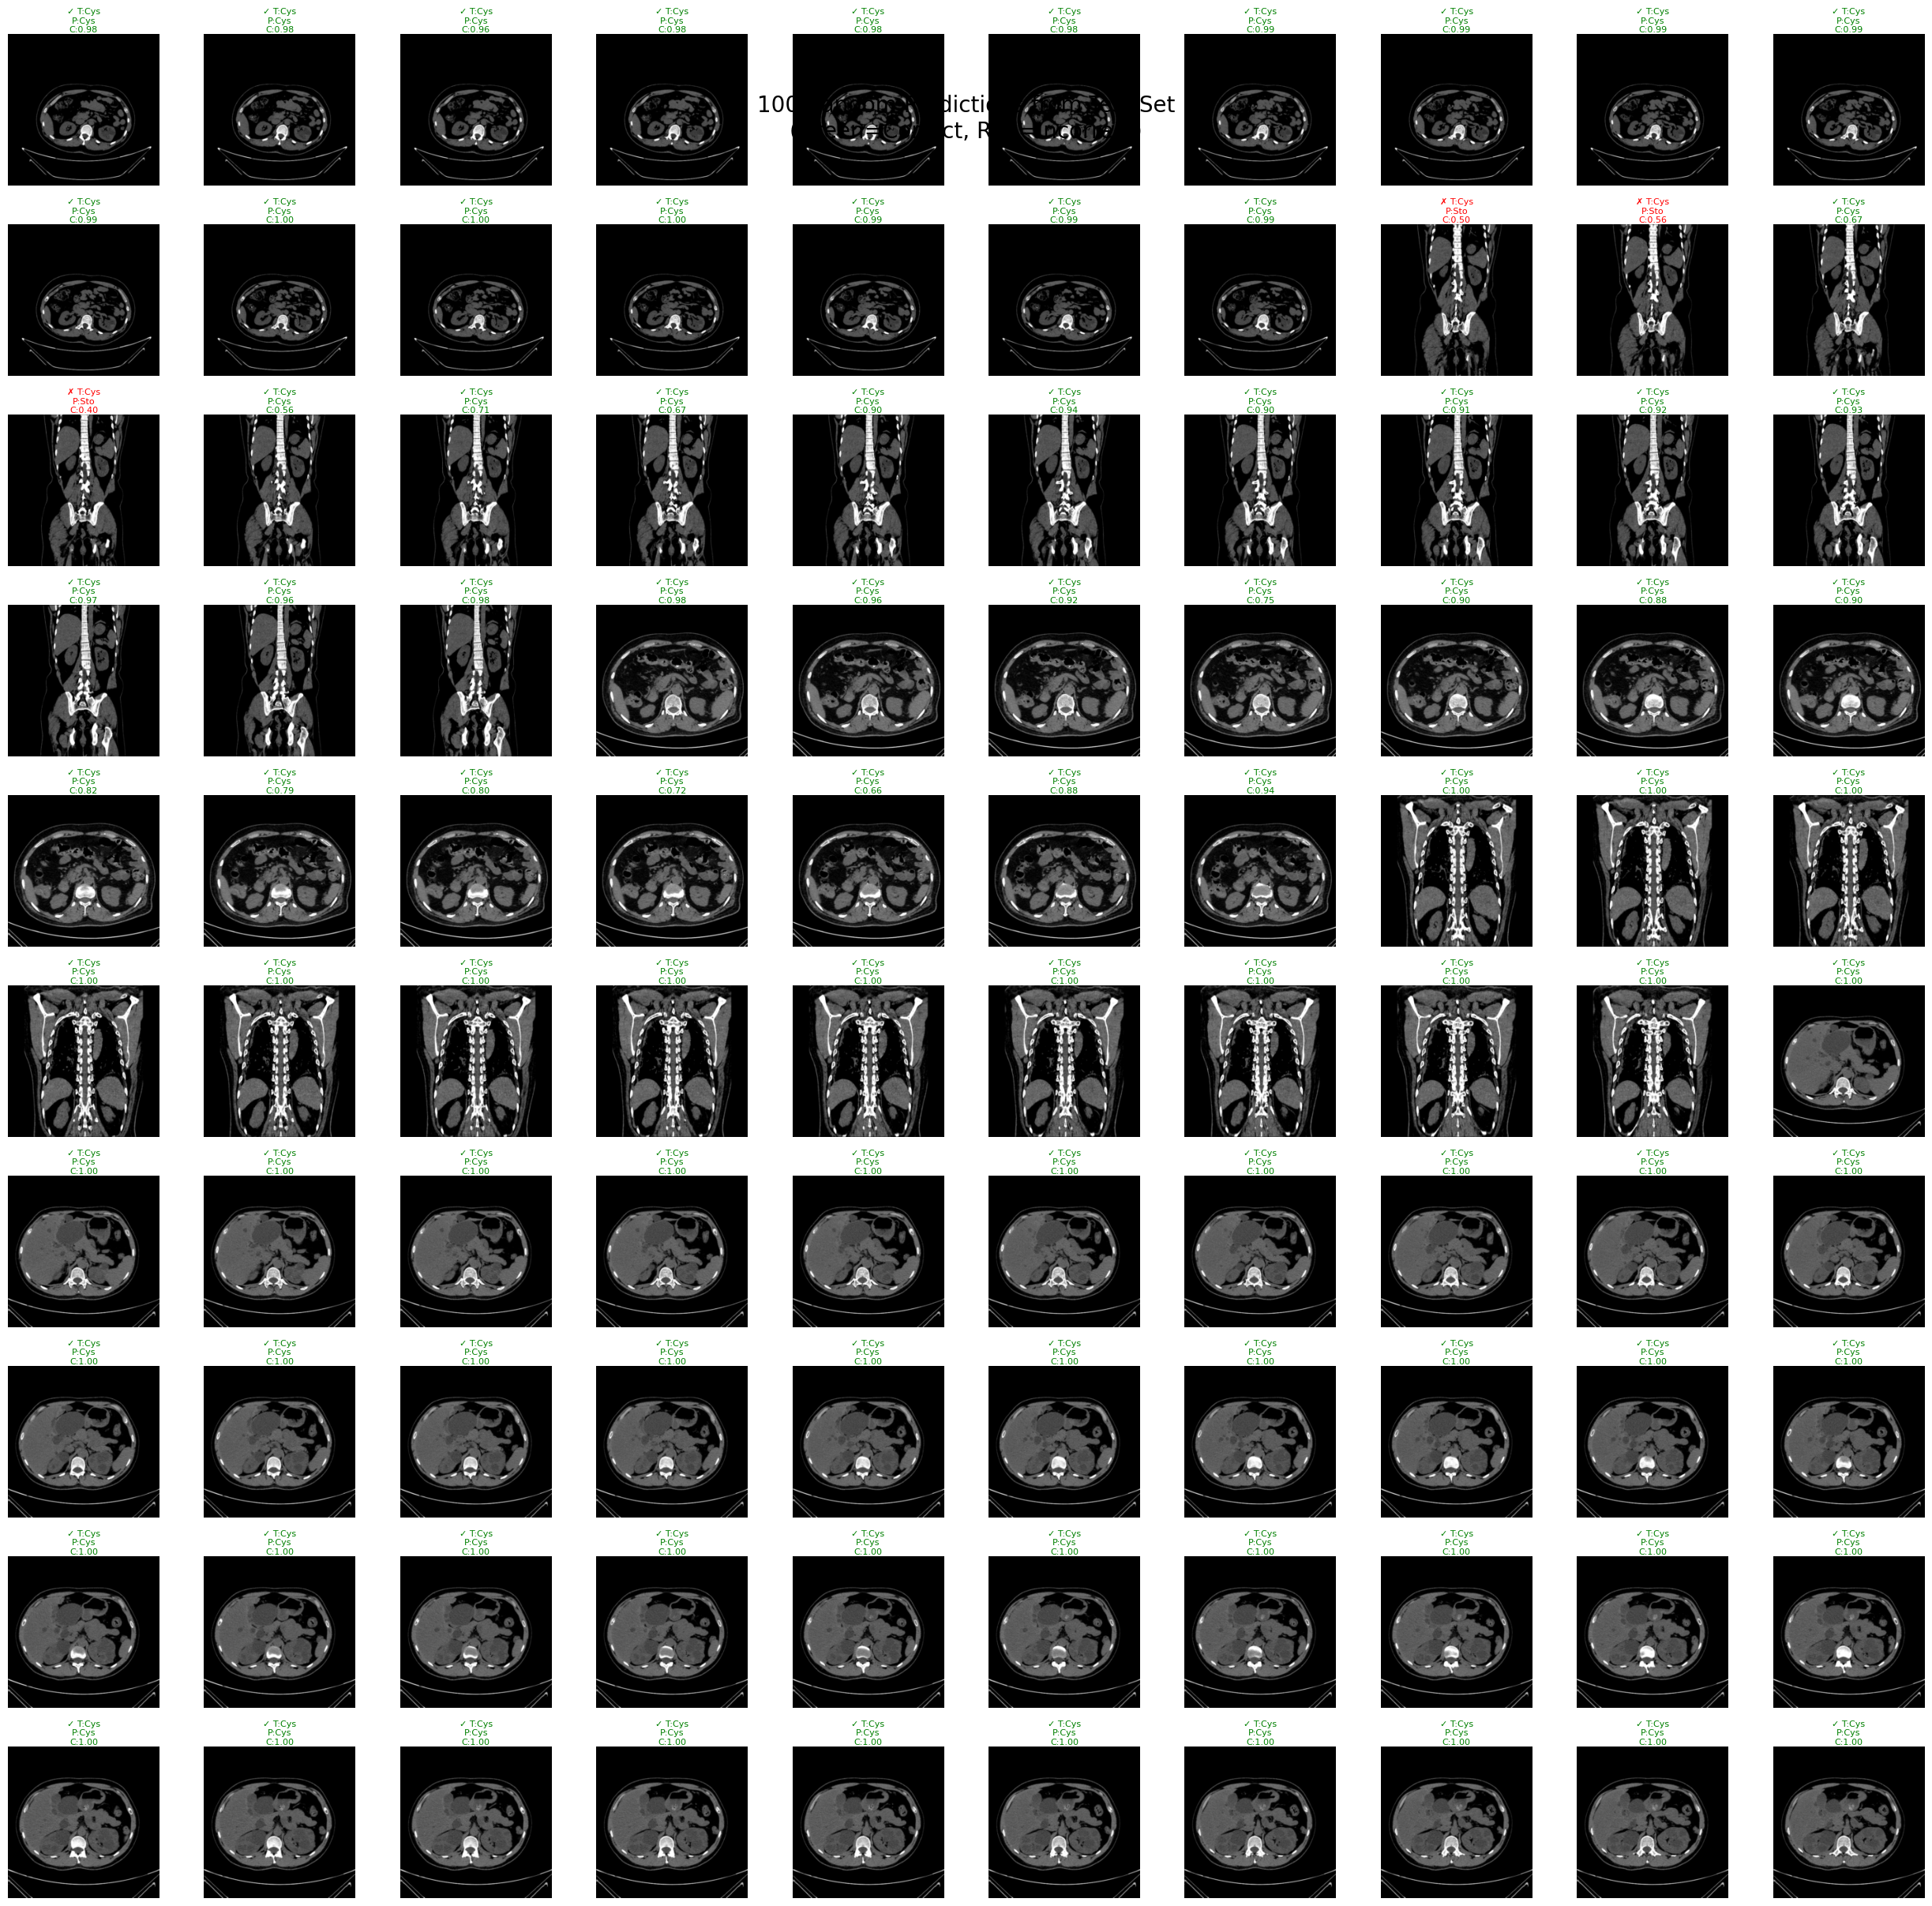


📊 ANALYSIS OF 100 PREDICTIONS:
Overall Accuracy: 97.0% (97/100 correct)
Average Confidence: 0.941
Average Confidence (Correct): 0.955
Average Confidence (Incorrect): 0.487

Per-Class Accuracy:
  Cyst: 97.0% (97/100)

Confidence Analysis:
  High-confidence (>0.8) correct: 88
  High-confidence (>0.8) incorrect: 0

Most Common Misclassifications:
  Cyst → Normal: 3 samples


IndexError: index 2 is out of bounds for axis 1 with size 2

In [32]:
# ================================
# ENHANCED PREDICTIONS VISUALIZATION - 100 SAMPLES
# ================================

def visualize_100_predictions(model, dataloader, class_names, num_samples=100):
    """
    Visualize 100 different predictions from the test set
    """
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []
    all_probs = []
    all_confidences = []
    
    # Collect 100 different samples from the dataloader
    with torch.no_grad():
        total_collected = 0
        for images, labels in dataloader:
            if total_collected >= num_samples:
                break
                
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, 1)
            confidences, _ = torch.max(probs, 1)
            
            # Add to collections
            batch_size = images.size(0)
            samples_to_take = min(batch_size, num_samples - total_collected)
            
            all_images.append(images[:samples_to_take].cpu())
            all_labels.append(labels[:samples_to_take].cpu())
            all_preds.append(preds[:samples_to_take].cpu())
            all_probs.append(probs[:samples_to_take].cpu())
            all_confidences.append(confidences[:samples_to_take].cpu())
            
            total_collected += samples_to_take
    
    # Concatenate all batches
    images = torch.cat(all_images, dim=0)
    labels = torch.cat(all_labels, dim=0)
    preds = torch.cat(all_preds, dim=0)
    probs = torch.cat(all_probs, dim=0)
    confidences = torch.cat(all_confidences, dim=0)
    
    print(f"✓ Collected {len(images)} samples for visualization")
    
    return images, labels, preds, probs, confidences

def plot_100_predictions_grid(images, labels, preds, confidences, class_names):
    """
    Plot 100 predictions in a 10x10 grid
    """
    fig, axes = plt.subplots(10, 10, figsize=(25, 25))
    axes = axes.ravel()
    
    for i in range(100):
        if i >= len(images):
            break
            
        img = images[i].permute(1, 2, 0)  # C,H,W -> H,W,C
        # Denormalize
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img)
        
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        confidence = confidences[i].item()
        
        # Color coding
        if true_label == pred_label:
            color = 'green'
            marker = '✓'
        else:
            color = 'red' 
            marker = '✗'
        
        title = f"{marker} T:{true_label[:3]}\nP:{pred_label[:3]}\nC:{confidence:.2f}"
        axes[i].set_title(title, color=color, fontsize=8, pad=2)
        axes[i].axis('off')
    
    # Remove empty subplots
    for i in range(len(images), 100):
        axes[i].axis('off')
    
    plt.suptitle(f"100 Random Predictions from Test Set\n(Green=Correct, Red=Incorrect)", 
                 fontsize=20, y=0.92)
    plt.tight_layout()
    plt.show()

def analyze_100_predictions(labels, preds, confidences, class_names):
    """
    Analyze the 100 predictions with statistics
    """
    labels_np = labels.numpy()
    preds_np = preds.numpy()
    confidences_np = confidences.numpy()
    
    # Calculate metrics
    correct_mask = (labels_np == preds_np)
    accuracy = np.mean(correct_mask)
    
    print(f"\n📊 ANALYSIS OF 100 PREDICTIONS:")
    print("=" * 50)
    print(f"Overall Accuracy: {accuracy:.1%} ({np.sum(correct_mask)}/100 correct)")
    print(f"Average Confidence: {np.mean(confidences_np):.3f}")
    print(f"Average Confidence (Correct): {np.mean(confidences_np[correct_mask]):.3f}")
    print(f"Average Confidence (Incorrect): {np.mean(confidences_np[~correct_mask]):.3f}")
    
    # Per-class accuracy
    print(f"\nPer-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = (labels_np == i)
        if np.sum(class_mask) > 0:
            class_acc = np.mean(preds_np[class_mask] == labels_np[class_mask])
            class_count = np.sum(class_mask)
            print(f"  {class_name}: {class_acc:.1%} ({np.sum(preds_np[class_mask] == labels_np[class_mask])}/{class_count})")
    
    # Confidence analysis
    print(f"\nConfidence Analysis:")
    high_conf_correct = np.sum((confidences_np > 0.8) & correct_mask)
    high_conf_incorrect = np.sum((confidences_np > 0.8) & ~correct_mask)
    print(f"  High-confidence (>0.8) correct: {high_conf_correct}")
    print(f"  High-confidence (>0.8) incorrect: {high_conf_incorrect}")
    
    # Most common errors
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(labels_np, preds_np)
    print(f"\nMost Common Misclassifications:")
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                print(f"  {class_names[i]} → {class_names[j]}: {cm[i, j]} samples")

def plot_prediction_distribution(labels, preds, confidences, class_names):
    """
    Plot distribution of predictions and confidences
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    labels_np = labels.numpy()
    preds_np = preds.numpy()
    confidences_np = confidences.numpy()
    correct_mask = (labels_np == preds_np)
    
    # Plot 1: Confidence distribution
    ax1.hist(confidences_np[correct_mask], alpha=0.7, label='Correct', bins=20, color='green')
    ax1.hist(confidences_np[~correct_mask], alpha=0.7, label='Incorrect', bins=20, color='red')
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('Count')
    ax1.set_title('Confidence Distribution: Correct vs Incorrect')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy by confidence bins
    confidence_bins = [0, 0.5, 0.7, 0.9, 1.0]
    bin_accuracies = []
    bin_counts = []
    
    for i in range(len(confidence_bins)-1):
        low, high = confidence_bins[i], confidence_bins[i+1]
        bin_mask = (confidences_np >= low) & (confidences_np < high)
        if np.sum(bin_mask) > 0:
            bin_accuracy = np.mean(correct_mask[bin_mask])
            bin_accuracies.append(bin_accuracy)
            bin_counts.append(np.sum(bin_mask))
        else:
            bin_accuracies.append(0)
            bin_counts.append(0)
    
    x_pos = np.arange(len(bin_accuracies))
    bars = ax2.bar(x_pos, bin_accuracies, color='skyblue', alpha=0.7)
    ax2.set_xlabel('Confidence Range')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy by Confidence Bins')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(['0-0.5', '0.5-0.7', '0.7-0.9', '0.9-1.0'])
    ax2.grid(True, alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars, bin_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'n={count}', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Class distribution
    true_counts = [np.sum(labels_np == i) for i in range(len(class_names))]
    pred_counts = [np.sum(preds_np == i) for i in range(len(class_names))]
    
    x = np.arange(len(class_names))
    width = 0.35
    ax3.bar(x - width/2, true_counts, width, label='True', alpha=0.7)
    ax3.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.7)
    ax3.set_xlabel('Classes')
    ax3.set_ylabel('Count')
    ax3.set_title('True vs Predicted Class Distribution')
    ax3.set_xticks(x)
    ax3.set_xticklabels(class_names)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Error cases analysis
    error_indices = np.where(~correct_mask)[0]
    if len(error_indices) > 0:
        error_true_classes = [class_names[labels_np[i]] for i in error_indices]
        error_pred_classes = [class_names[preds_np[i]] for i in error_indices]
        
        error_pairs = [f"{true}→{pred}" for true, pred in zip(error_true_classes, error_pred_classes)]
        unique_errors, error_counts = np.unique(error_pairs, return_counts=True)
        
        ax4.barh(unique_errors, error_counts, color='lightcoral')
        ax4.set_xlabel('Count')
        ax4.set_title('Most Common Error Types')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ================================
# MAIN EXECUTION - GET 100 PREDICTIONS
# ================================

print("🔄 Collecting 100 random predictions from test set...")

# Get 100 different predictions
images, labels, preds, probs, confidences = visualize_100_predictions(
    model, test_loader, class_names, num_samples=100
)

# Plot 10x10 grid of predictions
plot_100_predictions_grid(images, labels, preds, confidences, class_names)

# Detailed analysis
analyze_100_predictions(labels, preds, confidences, class_names)

# Distribution plots
plot_prediction_distribution(labels, preds, confidences, class_names)

print("✅ 100 predictions analysis completed!")